In [1]:
import pandas as pd
import json

import string
import re

import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lqlau\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lqlau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lqlau\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lqlau\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
voc_df = pd.read_csv("Voice of Customer.csv")
voc_df = voc_df[~voc_df["voice of customer"].str.contains("NIL")].reset_index(drop=True)
voc_df

id             satisfaction  satisfaction score  \
0         72  neutral or dissatisfied                   3   
1         93  neutral or dissatisfied                   3   
2        109  neutral or dissatisfied                   4   
3        147  neutral or dissatisfied                   4   
4        244  neutral or dissatisfied                   4   
...      ...                      ...                 ...   
2158  129647  neutral or dissatisfied                   3   
2159  129709  neutral or dissatisfied                   4   
2160  129721  neutral or dissatisfied                   4   
2161  129814  neutral or dissatisfied                   4   
2162  129866  neutral or dissatisfied                   3   

                                      voice of customer  
0     The emotional toll of the experience was overw...  
1     The extended wait for flight arrival was highl...  
2     The airline did not provide any updates during...  
3     The airline did not provide any compensation f...  
4       The airline charged excessive fees for baggage.  
...                                                 ...  
2158  Faulty and unreliable onboard entertainment sy...  
2159  The cabin lacked proper disposal for used napk...  
2160  The airline lacked efficiency in managing flig...  
2161  I encountered a delay in receiving my requeste...  
2162  The flight had a lack of space for passengers ...  

[2163 rows x 4 columns]

In [3]:
satisfaction_df = pd.read_csv("Airline Passenger Satisfaction.csv")
satisfaction_df.drop(columns=['Unnamed: 0'], inplace=True)

voc_combined = satisfaction_df[satisfaction_df['id'].isin(voc_df['id'])]

voc_combined = voc_df.merge(voc_combined, on=['id', 'satisfaction', 'satisfaction score'],
                how='left')

In [4]:
no_delays = voc_combined[(voc_combined['Departure Delay in Minutes'] == 0) & (voc_combined['Arrival Delay in Minutes'] == 0)]
delays = voc_combined[~(voc_combined['Departure Delay in Minutes'] == 0) | ~(voc_combined['Arrival Delay in Minutes'] == 0)]

In [5]:
no_delays
delays

id             satisfaction  satisfaction score  \
0         72  neutral or dissatisfied                   3   
1         93  neutral or dissatisfied                   3   
2        109  neutral or dissatisfied                   4   
3        147  neutral or dissatisfied                   4   
4        244  neutral or dissatisfied                   4   
...      ...                      ...                 ...   
2155  129122  neutral or dissatisfied                   3   
2156  129157  neutral or dissatisfied                   3   
2159  129709  neutral or dissatisfied                   4   
2160  129721  neutral or dissatisfied                   4   
2162  129866  neutral or dissatisfied                   3   

                                      voice of customer  Gender  \
0     The emotional toll of the experience was overw...    Male   
1     The extended wait for flight arrival was highl...  Female   
2     The airline did not provide any updates during...  Female   
3     The airline did not provide any compensation f...  Female   
4       The airline charged excessive fees for baggage.    Male   
...                                                 ...     ...   
2155  I had to endure a lengthy delay in flight depa...    Male   
2156  I am boiling with anger! This airline's delays...  Female   
2159  The cabin lacked proper disposal for used napk...    Male   
2160  The airline lacked efficiency in managing flig...  Female   
2162  The flight had a lack of space for passengers ...    Male   

          Customer Type  Age   Type of Travel     Class  Flight Distance  ...  \
0        Loyal Customer   53  Business travel  Business             3201  ...   
1        Loyal Customer   43  Business travel  Business             3513  ...   
2        Loyal Customer   72  Business travel  Business             1954  ...   
3        Loyal Customer   47  Business travel  Business             1946  ...   
4     disloyal Customer   30  Business travel  Business              719  ...   
...                 ...  ...              ...       ...              ...  ...   
2155     Loyal Customer   50  Business travel  Business              679  ...   
2156     Loyal Customer   25  Business travel  Business              679  ...   
2159     Loyal Customer   39  Business travel  Business              447  ...   
2160     Loyal Customer   51  Business travel       Eco              337  ...   
2162     Loyal Customer   64  Business travel  Eco Plus              337  ...   

      Seat comfort  Inflight entertainment  On-board service  \
0                3                       2                 2   
1                3                       1                 1   
2                1                       4                 5   
3                2                       4                 1   
4                3                       3                 2   
...            ...                     ...               ...   
2155             3                       1                 1   
2156             2                       2                 1   
2159             3                       2                 2   
2160             3                       1                 1   
2162             2                       2                 1   

      Leg room service  Baggage handling  Checkin service  Inflight service  \
0                    1                 3                3                 2   
1                    1                 1                2                 1   
2                    3                 2                1                 4   
3                    4                 4                2                 2   
4                    2                 2                1                 2   
...                ...               ...              ...               ...   
2155                 3                 4                3                 2   
2156                 2                 3                3                 3   
2159               

<h1> Preprocessing </h1> 

1. Convert to lowercase
2. Convert contractions
3. Remove puncutations
4. Remove numbers
5. remove stopwords
6. Lemmazation 

In [6]:
with open ('./contractions.json') as f:
    contractions_dict = json.load(f)

def contractions_cleaning(sentence):
    return ' '.join([contractions_dict.get(word, word) for word in sentence.split()])

def sentence_preprocessing(df, col):
    df[col] = df[col].str.lower() # convert to lowercase
    df[col] = df[col].apply(contractions_cleaning) # expand contractions
    df[col] = df[col].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ' , x)) # remove puncutations
    df[col] = df[col].apply(lambda x : re.sub(r"\d+", " ", x)) # remove numbers
    return df[col]

def remove_stopwords(sentence):
    return ' '.join([word for word in sentence.split() if not word in stop_words])

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].lower()
    tag_dict = {"a": wordnet.ADJ,
                  "n": wordnet.NOUN,
                  "v": wordnet.VERB,
                  "r": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    sentence = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence.split()])
    return sentence

In [7]:
stop_words = set(stopwords.words('english'))

voc_df['voice of customer'] = sentence_preprocessing(voc_df, 'voice of customer')
no_delays['voice of customer'] = sentence_preprocessing(no_delays, 'voice of customer')
delays['voice of customer'] = sentence_preprocessing(delays, 'voice of customer')

voc_df['voice of customer'] = voc_df['voice of customer'].apply(remove_stopwords)
no_delays['voice of customer'] = no_delays['voice of customer'].apply(remove_stopwords)
delays['voice of customer'] = delays['voice of customer'].apply(remove_stopwords)

voc_df['voice of customer'] = voc_df['voice of customer'].apply(lemmatize_sentence)
no_delays['voice of customer'] = no_delays['voice of customer'].apply(lemmatize_sentence)
delays['voice of customer'] = delays['voice of customer'].apply(lemmatize_sentence)

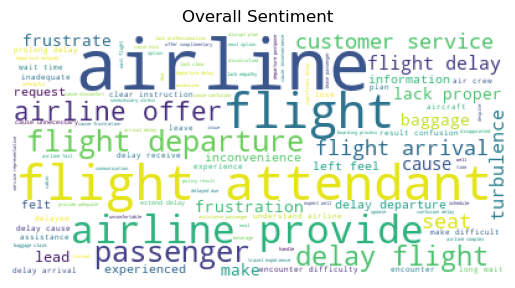

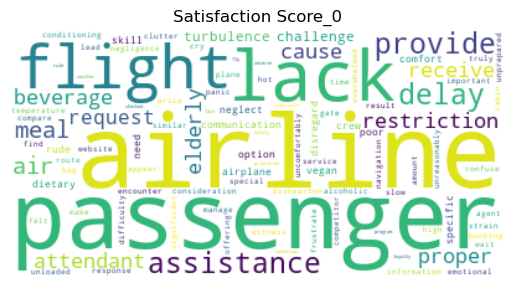

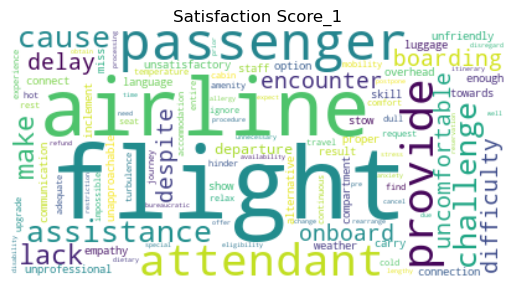

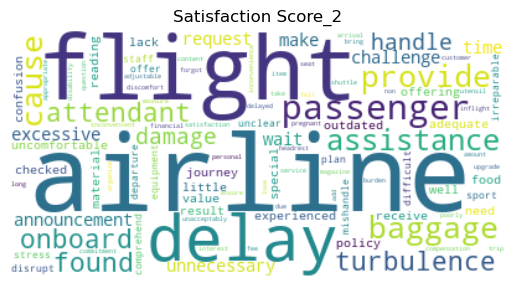

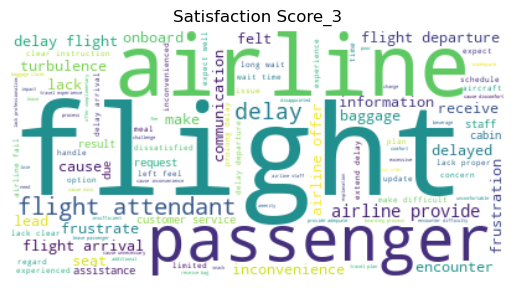

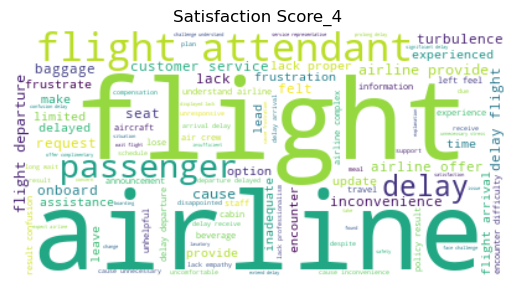

In [8]:
stopwords = set(STOPWORDS)

text = ' '.join([word for word in voc_df['voice of customer']])

wordcloud = WordCloud(stopwords=stopwords, 
                      max_words=100, 
                      background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Overall Sentiment")
plt.savefig("./overall/overall.png")
plt.show()

for i in range(len(voc_df['satisfaction score'].unique())): 
    text = ' '.join([word for word in voc_df['voice of customer'].loc[voc_df['satisfaction score'] == i]])
    wordcloud = WordCloud(stopwords=stopwords, 
                          max_words=100, 
                          background_color='white').generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    title = f'Satisfaction Score_{i}'
    plt.title(title)

    plt.savefig(f"./overall/{title}.png")
    plt.show()

Remove airline, flight, passenger from wordcloud

In [9]:
voc_df['voice of customer'] = voc_df['voice of customer'].str.replace("airline", "")
voc_df['voice of customer'] = voc_df['voice of customer'].str.replace("flight", "")
voc_df['voice of customer'] = voc_df['voice of customer'].str.replace("passenger", "")

no_delays['voice of customer'] = no_delays['voice of customer'].str.replace("airline", "")
no_delays['voice of customer'] = no_delays['voice of customer'].str.replace("flight", "")
no_delays['voice of customer'] = no_delays['voice of customer'].str.replace("passenger", "")

delays['voice of customer'] = delays['voice of customer'].str.replace("airline", "")
delays['voice of customer'] = delays['voice of customer'].str.replace("flight", "")
delays['voice of customer'] = delays['voice of customer'].str.replace("passenger", "")

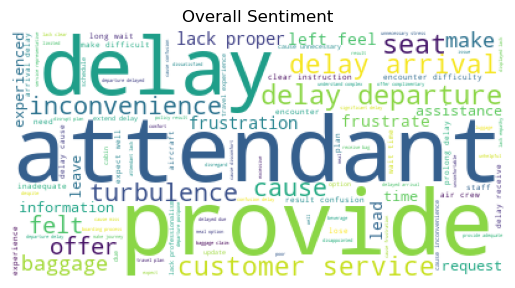

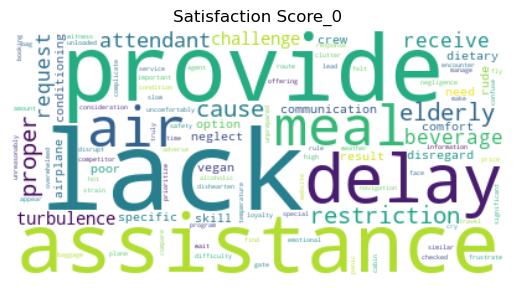

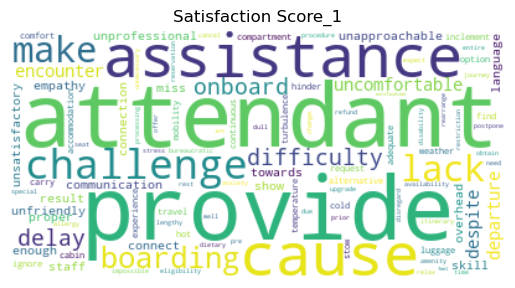

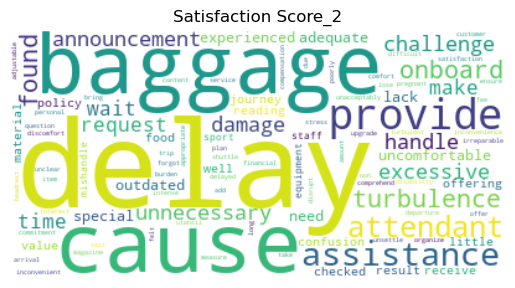

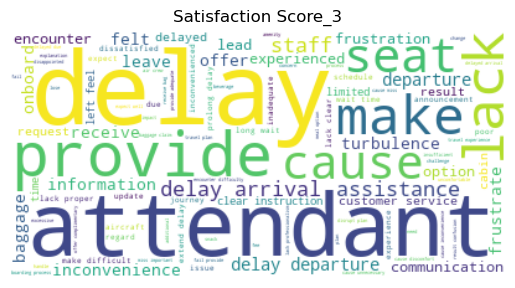

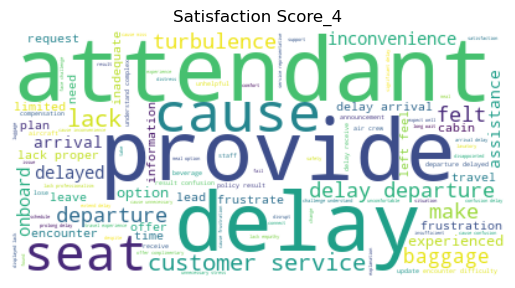

In [10]:
text = ' '.join([word for word in voc_df['voice of customer']])

wordcloud = WordCloud(stopwords=stopwords, 
                      max_words=100, 
                      background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Overall Sentiment")
plt.savefig("./overall/overall.png")
plt.show()

for i in range(len(voc_df['satisfaction score'].unique())): 
    text = ' '.join([word for word in voc_df['voice of customer'].loc[voc_df['satisfaction score'] == i]])
    wordcloud = WordCloud(stopwords=stopwords, 
                          max_words=100, 
                          background_color='white').generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    title = f'Satisfaction Score_{i}'
    plt.title(title)

    plt.savefig(f"./overall/{title}.png")
    plt.show()

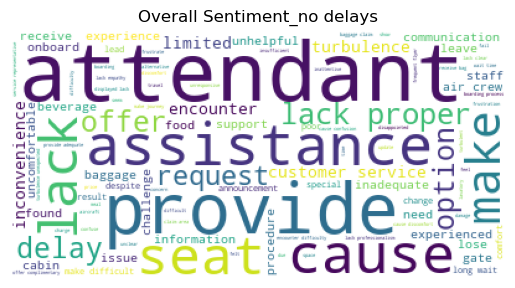

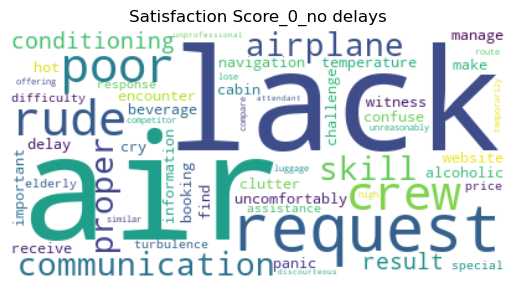

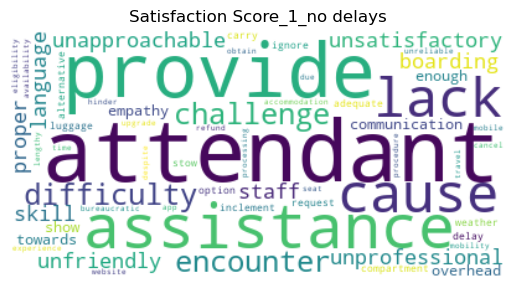

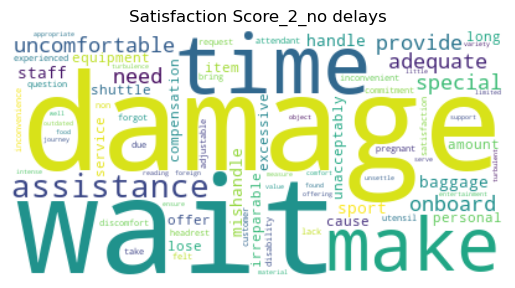

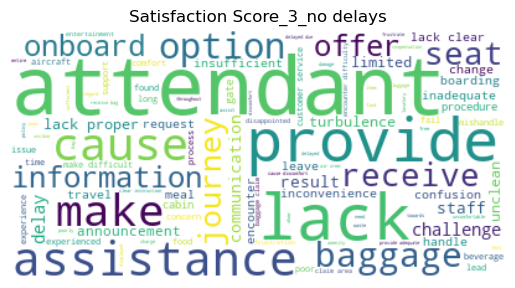

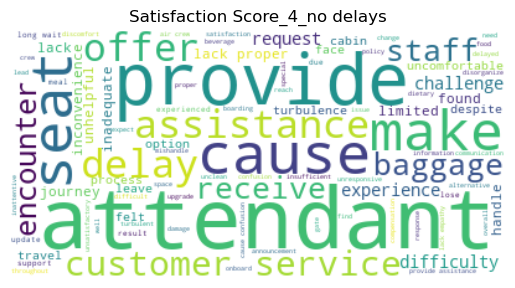

In [11]:
text = ' '.join([word for word in no_delays['voice of customer']])
wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Overall Sentiment_no delays")
plt.savefig("./no_delays/overall.png")
plt.show()

for i in range(len(no_delays['satisfaction score'].unique())): 
    text = ' '.join([word for word in no_delays['voice of customer'].loc[no_delays['satisfaction score'] == i]])
    wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color='white').generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    title = f'Satisfaction Score_{i}_no delays'
    plt.title(title)

    plt.savefig(f"./no_delays/{title}.png")
    plt.show()

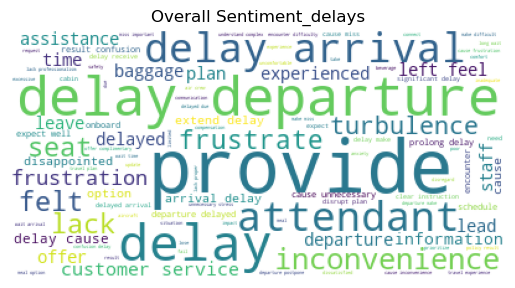

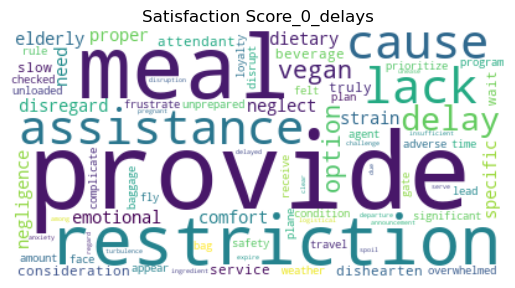

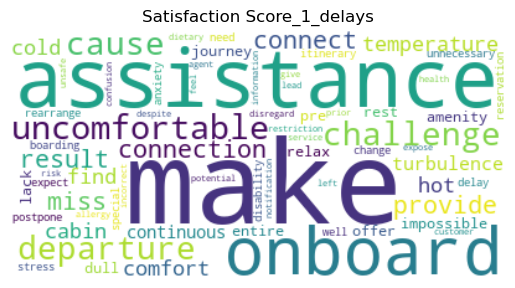

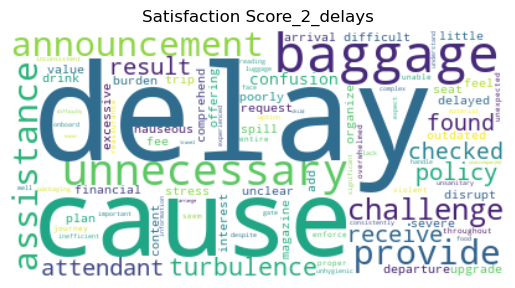

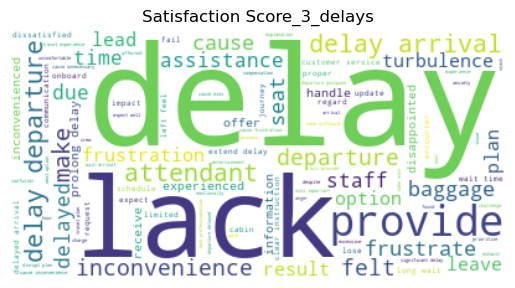

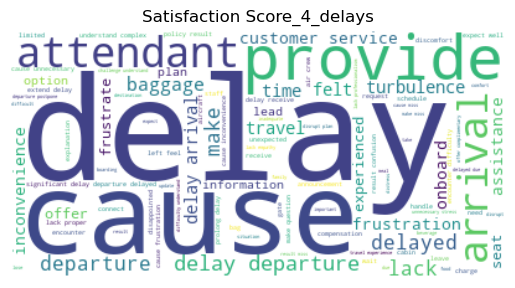

In [12]:
text = ' '.join([word for word in delays['voice of customer']])
wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Overall Sentiment_delays")
plt.savefig("./delays/overall.png")
plt.show()

for i in range(len(delays['satisfaction score'].unique())): 
    text = ' '.join([word for word in delays['voice of customer'].loc[delays['satisfaction score'] == i]])
    wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color='white').generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    title = f'Satisfaction Score_{i}_delays'
    plt.title(title)

    plt.savefig(f"./delays/{title}.png")
    plt.show()